In [514]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

print(np.__version__)
print(cv2.__version__)

1.20.3
4.5.5


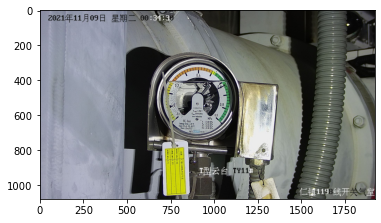

In [515]:
im = cv2.imread('data/sf3/33010110010311101111_20211109T003047Z.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

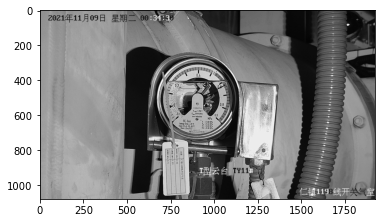

In [516]:
# convert to gray image for processing
im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
plt.imshow(im_gray, 'gray')

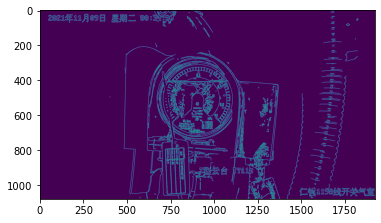

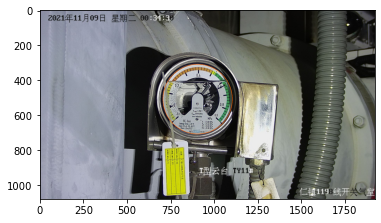

In [517]:
# extract the panel from image
im_edges = cv2.Canny(im_gray, 500, 200)
plt.imshow(im_edges)
plt.show()
circles = cv2.HoughCircles(im_edges, cv2.HOUGH_GRADIENT, 2, im_gray.shape[0]//4, 
    param1=200, param2=100, minRadius=50, maxRadius=200)
circles = np.uint16(np.around(circles))
circle = circles[0][0]
vis = im.copy()
vis = cv2.circle(vis, (circle[0], circle[1]), circle[2], (250, 100, 0), 2)
plt.imshow(vis)

In [518]:
def DrawCircles(im, circles):
    vis = im.copy()
    for i in range(circles.shape[0]):
        vis = cv2.circle(vis, (circles[i][0], circles[i][1]), circles[i][2], (250, 100, 0), 2)
    return vis

vis_circles = DrawCircles(im, circles[0])
plt.imshow(vis_circles)
plt.show()

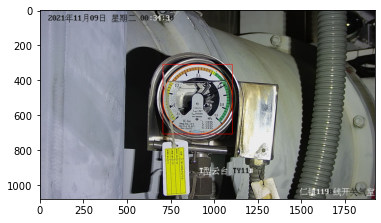

In [519]:
# find the bounding box of the circle of panel
# left top 
x = max(0, circle[0] - circle[2])
y = max(0, circle[1] - circle[2])
w = min(2*circle[2], min(im.shape[1]-1-x, im.shape[0]-1-y))
h = w
vis = cv2.rectangle(vis, (x,y), (x + w, y+h), (255, 0, 0), 2, 8)
plt.imshow(vis)

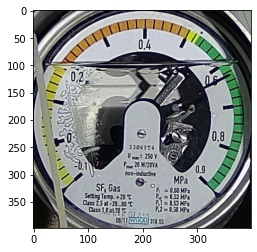

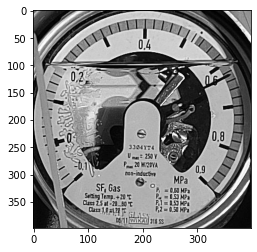

In [520]:
# cut out the panel
im_panel = im[y:y+h, x:x+w]
plt.imshow(im_panel)
plt.show()
gray_panel = im_gray[y:y+h, x:x+w]
plt.imshow(gray_panel, 'gray')

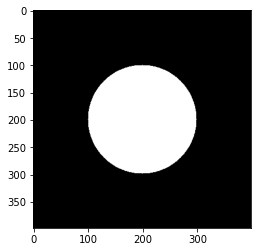

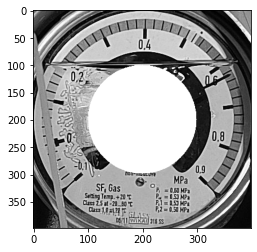

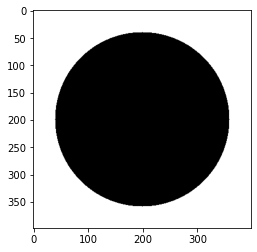

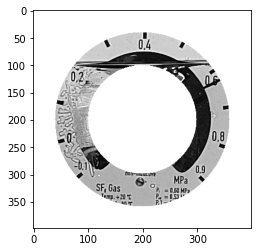

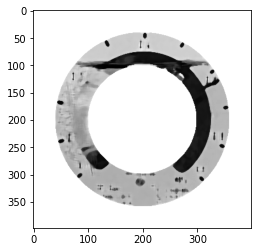

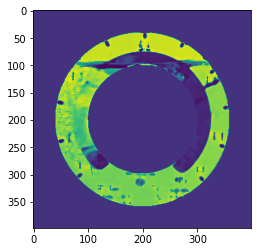

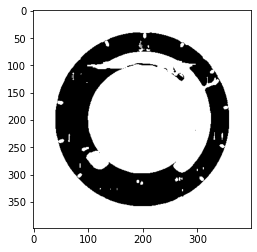

In [521]:
# leverage the contrast
im_tmp = np.zeros(gray_panel.shape, gray_panel.dtype)
h, w = im_tmp.shape
crop_ratio = 0.5
vis_crop = cv2.circle(im_tmp, (h//2, w//2), int(w/2*crop_ratio), (255), -1)
plt.imshow(vis_crop, 'gray')
plt.show()
gray_panel = cv2.bitwise_or(vis_crop, gray_panel)
plt.imshow(gray_panel, 'gray')
plt.show()

# paint the outer ring to white
mask_ring = np.zeros(gray_panel.shape, gray_panel.dtype) + 255
ring_ratio = 0.8
vis_ring = cv2.circle(mask_ring, (h//2, w//2), int(w/2*ring_ratio), (0), -1)
plt.imshow(vis_ring, 'gray')
plt.show()

gray_panel = cv2.bitwise_or(vis_ring, gray_panel)
plt.imshow(gray_panel, 'gray')
plt.show()


plt.imsave('gray_panel_crop.png', gray_panel)
gray_panel_blur = cv2.medianBlur(gray_panel, 7)
plt.imshow(gray_panel_blur, 'gray')
plt.show()
ratio = 255.0 / max(gray_panel_blur.mean(),1e-5)
gray_panel_blur = np.uint8(gray_panel_blur*ratio)
plt.imshow(gray_panel_blur)
plt.show()
im_thresh = gray_panel_blur < 80
plt.imshow(im_thresh, 'gray')
plt.show()

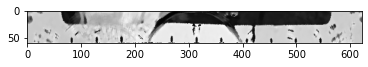

In [522]:
def RingToRect(_ring, r1, r2, theta_start, theta_stop):
    assert _ring.dtype == np.uint8
    assert theta_start < theta_stop
    h0, w0 = _ring.shape
    h = int(r2 - r1)
    assert h > 0
    w = int((theta_stop - theta_start) * r1)
    _rect = np.zeros([h, w], np.uint8)
    for i in range(h):
        for j in range(w):
            r = i + r1
            theta = j / w * (theta_stop - theta_start) + theta_start
            x = -r*np.sin(theta)
            y = -r*np.cos(theta)
            u = int(w0/2 + x)
            v = int(h0/2 - y)
            _rect[i,j] = _ring[v, u]
    return _rect


r1 = crop_ratio * gray_panel.shape[0]//2
r2 = ring_ratio * gray_panel.shape[0]//2

#gray_rect = RingToRect(gray_panel_blur, r1, r2, np.pi/4.0, 2*np.pi-np.pi/4.0)
gray_rect = RingToRect(gray_panel_blur, r1, r2, 0, 2*np.pi)
plt.imshow(gray_rect, 'gray')
plt.show()

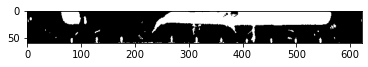

True

In [523]:
im_thresh = np.uint8(gray_rect < 80)*255
plt.imshow(im_thresh, 'gray')
plt.show()
cv2.imwrite('ring_to_rect.png', im_thresh)

0.7407407407407407
420


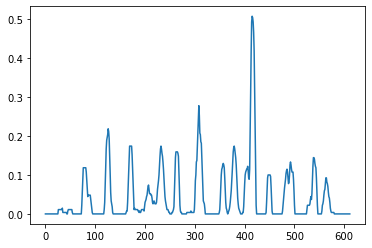

the read is: 0.634


In [524]:
# convolution to get the best match of pointer
ksize = 10
r0 = ksize//2
h, w = im_thresh.shape
max_sum = 0
max_id = -1
response = np.zeros([w-r0-r0], np.float32)
for i in range(r0, w-1-r0, 1):
    _sum = np.mean(im_thresh[:,(i-r0):(i+r0-1)])/255.0
    response[i-r0] = np.mean(im_thresh[h//2:,(i-r0):(i+r0-1)])/255.0
    if _sum > max_sum:
        max_sum = _sum
        max_id = i
print(max_sum)
print(max_id)

plt.plot(response)
plt.show()

# get the final digit read
start_pos = 0.125 * w
stop_pos = (1 - 0.125)*w
digit = (max_id - start_pos) / (stop_pos - start_pos) - 0.1
print('the read is: %.3f' % digit)


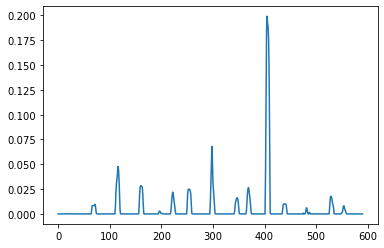

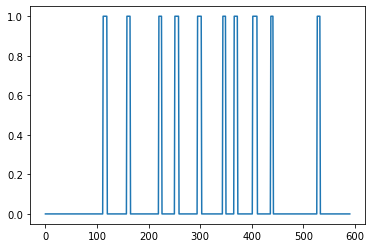

In [525]:
# get gradient curves
step = 10
w1 = len(response)
grad_x = response[step:w1-1-step] - response[0:w1-1-2*step]
grad_y = response[step:w1-1-step] - response[2*step:w1-1]
sign = (grad_x > 0) * (grad_y > 0)
grad = sign * np.abs(grad_x) * np.abs(grad_y)

plt.plot(grad)
plt.show()

# find all meters
regions = np.float32(grad > 0.01)
plt.plot(regions)
plt.show()

In [526]:
# get the discrete numbers of meters of each region
last_val = -1.0
meters_left = []
meters_right = []
for i in range(len(regions)):
    this_val = regions[i]
    if last_val == 0.0 and this_val == 1.0:
        meters_left += [i]
    if last_val == 1.0 and this_val == 0.0:
        meters_right += [i]
    last_val = this_val

assert len(meters_left)==len(meters_right)
meters = (np.array(meters_left) + np.array(meters_right)) // 2
print(meters)

meters = meters + step + ksize//2
# remove the pointer
if len(meters)==12:
    _id = np.argmin(np.abs(meters - max_id))
    meters_real = []
    for i in range(len(meters)):
        if i != _id:
            meters_real.append(meters[i])
    meters = meters_real
print(meters)
print(len(meters))

assert len(meters) >= 11
while len(meters) > 11:
    meters = meters[1:-1]
assert len(meters) == 11

[116 161 223 255 299 347 369 406 439 530]
[131 176 238 270 314 362 384 421 454 545]
10


AssertionError: 

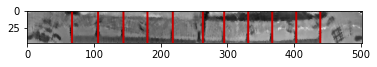

In [ ]:
# draw them on the panel
vis_ring = cv2.cvtColor(gray_rect, cv2.COLOR_GRAY2RGB)
for _id in meters:
     vis_ringl = cv2.line(vis_ring, (_id, 0), (_id, h), (200, 0, 0), 2)
plt.imshow(vis_ring)
plt.show()

[0.82607616 1.31421207 1.78983167 2.24041867 2.71603827 3.27927201
 3.67979379 4.13038078 4.58096777 5.03155477 5.48214176]


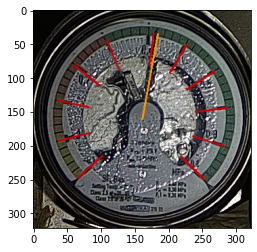

In [ ]:
# remap to the original panel image
meter_angles = 1.0*(meters - 1) / gray_rect.shape[1] * 2.0*np.pi
print(meter_angles)

# draw meters on panel
h, w, _ = im_panel.shape
vis_meters = im_panel.copy()
for _angle in meter_angles:
    x1 = int(w / 2.0 - r1 * np.sin(_angle))
    y1 = int(h / 2.0 + r1 * np.cos(_angle))
    x2 = int(w / 2.0 - r2 * np.sin(_angle))
    y2 = int(h / 2.0 + r2 * np.cos(_angle))
    vis_meters = cv2.line(vis_meters, (x1, y1), (x2, y2), (200, 0, 0), 2)
# draw the pointer
pointer_angle = (max_id - 1) * 1.0 / gray_rect.shape[1] * 2.0 * np.pi
x1 = int(w / 2.0)
y1 = int(h / 2.0)
x2 = int(w / 2.0 - r2 * np.sin(pointer_angle))
y2 = int(h / 2.0 + r2 * np.cos(pointer_angle))
vis_meters = cv2.line(vis_meters, (x1, y1), (x2, y2), (250, 150, 0), 2)

plt.imshow(vis_meters)
plt.show()


0.4376344086021505


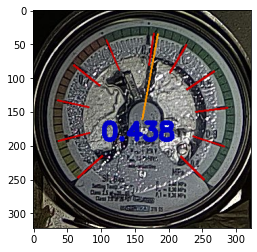

In [ ]:
# correct the final read digit
final_read = (pointer_angle - meter_angles[0]) / (meter_angles[-1] - meter_angles[0]) - 0.1
print(final_read)

# draw the digit on panel
vis_meters_pointer = cv2.putText(vis_meters, '%.3f' % final_read, (w//2 - 60, h//2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 200), 6)
plt.imshow(vis_meters_pointer)
plt.show()
plt.imsave('vis_meters_pointer.png', vis_meters_pointer)